In [1]:
import os
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_gpt import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(1)

In [2]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [3]:
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
general_prompts = pd.read_csv("data/processed/general_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = (
    pd.concat([law_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)
healthcare_dataset = (
    pd.concat([healthcare_prompts, general_prompts])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset = (
    pd.concat([finance_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
)

datasets = {
    #"law": law_dataset,
    #"healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [4]:
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
general_prompts_interim = pd.read_csv("data/interim/general_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = (
    pd.concat([law_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
healthcare_dataset_interim = (
    pd.concat([healthcare_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)
finance_dataset_interim = (
    pd.concat([finance_prompts_interim, general_prompts_interim])
    .sample(frac=1)
    .reset_index(drop=True)
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

In [5]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", 
    providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

2025-03-16 18:40:34.768640697 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-03-16 18:40:34.768703529 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-03-16 18:40:35.392253630 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-03-16 18:40:35.392327465 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [6]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda


# GPT and ModernBERT loop using interim data

In [ ]:
for domain, dataset in datasets_interim.items():
    # Split data
    train_data = dataset.sample(n=800)
    test_data = dataset.drop(train_data.index).sample(n=4000)

    # GPT Classifier
    gpt_classifier = GPT4oMini(
        api_key=os.getenv("OPENAI_API_KEY"),
        proxy_url=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )

    try:
        # DSPy optimization
        gpt_classifier.optimize_model()

        # Get predictions and metrics for test data
        test_predictions, test_actuals, test_latency = gpt_classifier.predict()
        test_latency = statistics.mean(test_latency)

        test_predictions = [int(pred) for pred in test_predictions]
        test_actuals = [int(actual) for actual in test_actuals]
        test_acc = metrics.accuracy_score(test_actuals, test_predictions)

        # Evaluate and save model
        evaluate(
            predictions=test_predictions,
            true_labels=test_actuals,
            domain=domain,
            model_name="gpt4o-mini",
            embed_model="ada-002",
            cost=gpt_classifier.cost,
            latency=test_latency,
            train_acc=test_acc
        )

        gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    except Exception as e:
        print(f"Error running GPT model: {e}")


    try:
        test_data = dataset.sample(n=30_000)
        # ModernBERT Classifier
        bert_classifier = ModernBERTNLI(domain=domain)
        bert_classifier.classifier.model.to("cuda")

        # Test predictions
        test_predictions = []
        test_times = []
        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            start_time = time.perf_counter_ns()
            pred = bert_classifier.predict(row["prompt"])
            test_predictions.append(pred)
            test_times.append(time.perf_counter_ns() - start_time)

        print(test_predictions)
        test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
        mean_prediction_time = statistics.mean(test_times)

        # Evaluate ModernBERT
        evaluate(
            predictions=test_predictions,
            true_labels=test_data["label"],
            domain=domain,
            model_name="modernbert",
            embed_model="bert-base",
            latency=mean_prediction_time,
            train_acc=test_acc
        )
    except Exception as e:
        print(f"Error running ModernBERT model: {e}")

# SVM, fastText and XGBoost loop using processed data

In [7]:
def train_and_evaluate_model(
    model_name: str,
    train_embeds: np.ndarray,
    test_embeds: np.ndarray,
    train_labels: pd.Series,
    test_labels: pd.Series,
    domain: str,
    embed_model: str,
    save_path: str,
    embedding_time: float = 0.0,
) -> None:

    # Initialize the classifier
    if model_name == "SVM":
        classifier = SVC(probability=True)
    elif model_name == "XGBoost":
        classifier = XGBClassifier(n_jobs=-1)
    else:
        raise ValueError("Invalid model_name. Choose 'SVM' or 'XGBoost'.")

    print(f"Training {embed_model} embeddings on {domain} domain using {model_name}")

    # Train the model
    classifier.fit(train_embeds, train_labels)

    train_predictions = classifier.predict(train_embeds)
    train_acc = metrics.accuracy_score(train_labels, train_predictions)

    predictions = []
    prediction_times = []

    # Evaluate the model on test data
    for _, test_embed in enumerate(
        tqdm(test_embeds, desc=f"Evaluating {model_name} on {domain}")
    ):
        start_time = time.perf_counter_ns()
        prediction = classifier.predict(test_embed.reshape(1, -1))
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)
        predictions.append(prediction[0])

    mean_prediction_time = statistics.mean(prediction_times)
    total_latency = mean_prediction_time + (embedding_time / len(test_embeds))

    # Save the model
    if model_name == "SVM":
        try:
            with open(save_path, "wb") as file:
                pickle.dump(classifier, file)
        except Exception as e:
            print(f"Error saving model: {e}")
    elif model_name == "XGBoost":
        classifier.save_model(save_path)


    # Evaluate the predictions
    evaluate(
        predictions,
        test_labels,
        domain,
        model_name=model_name,
        embed_model=embed_model,
        latency=total_latency,
        train_acc=train_acc,
    )

In [8]:
embedding_models = {
    #"mini": mini_embedding,
    #"tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [9]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']


Read 0M words
Number of words:  12921
Number of labels: 2
Progress: 100.0% words/sec/thread: 1747268 lr:  0.000000 avg.loss:  0.428725 ETA:   0h 0m 0s
100%|██████████| 9000/9000 [00:00<00:00, 20726.92it/s]


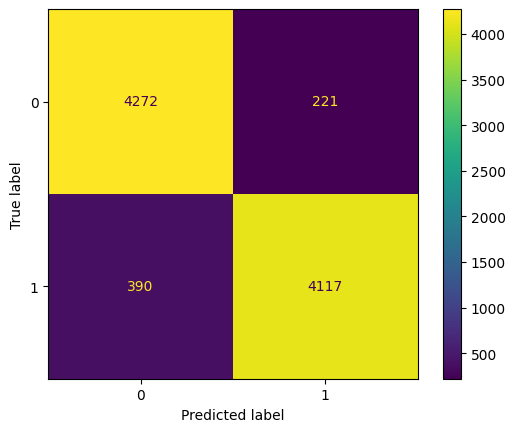

Training baai embeddings on finance domain using SVM


Evaluating SVM on finance: 100%|██████████| 9000/9000 [00:07<00:00, 1258.07it/s]


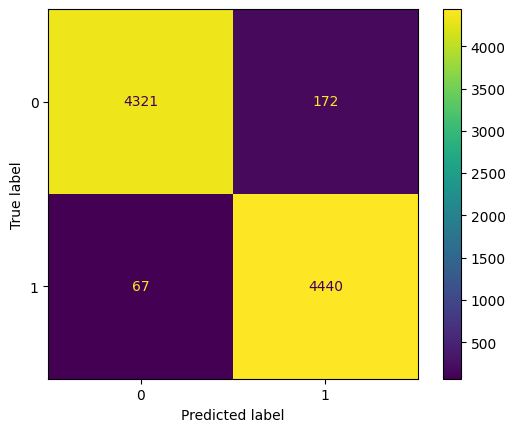

Training baai embeddings on finance domain using XGBoost


Evaluating XGBoost on finance: 100%|██████████| 9000/9000 [00:05<00:00, 1593.24it/s]


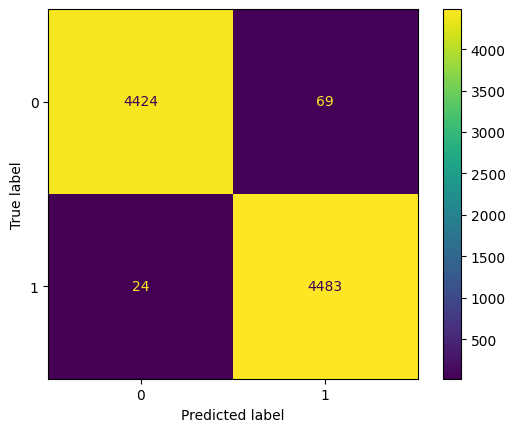

In [10]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.7).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    try:
        fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
        fasttext_classifier.train()

        train_predictions = []
        for _, row in train_data.iterrows():
            query = str(row["prompt"]).replace("\n", "")
            prediction = fasttext_classifier.model.predict(query)
            train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

        train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            text = str(row["prompt"])
            query = text.replace("\n", "")

            start_time = time.perf_counter_ns()
            prediction = fasttext_classifier.model.predict(query)
            end_time = time.perf_counter_ns()

            prediction_times.append(end_time - start_time)

            if prediction[0][0] == "__label__1":
                predictions.append(1)
            else:
                predictions.append(0)

            actuals.append(row["label"])

        mean_prediction_time = statistics.mean(prediction_times)

        evaluate(
            predictions,
            true_labels=actuals,
            domain=domain,
            model_name="fastText",
            embed_model="fastText",
            latency=mean_prediction_time,
            train_acc=train_acc,
        )

        fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")
    except Exception as e:
        print(f"Error running fastText model: {e}")

    for model_name, embedding_model in embedding_models.items():
        embed_times: float = None

        # Add timing for embedding creation
        if model_name == "tf_idf":
            embedding_model.fit(train_data["prompt"])

            with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                pickle.dump(embedding_model, f)

            # Time the transform process for training data
            start_time = time.perf_counter_ns()
            train_embeds = embedding_model.transform(train_data["prompt"])
            test_embeds = embedding_model.transform(test_data["prompt"])
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time
        else:
            # Time the embedding process for training data
            start_time = time.perf_counter_ns()
            train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
            test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time

        mean_embed_time = embed_times / len(train_data + test_data)

        try:
            # Train and evaluate SVM model
            train_and_evaluate_model(
                model_name="SVM",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/SVM_{domain}_{model_name}.pkl",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running SVM model: {e}")

        try:
            # Train and evaluate XGBoost model
            train_and_evaluate_model(
                model_name="XGBoost",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/XGBoost_{domain}_{model_name}.json",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running XGBoost model: {e}")